### Image Preturbation simulation

In [1]:
import warnings
warnings.filterwarnings('ignore')
import argparse
from tqdm import tqdm
from typing import Union, List, Tuple
import numpy as np
import torch
from torchvision import datasets
from torch import nn, optim, autograd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import random
from pathlib import Path
from sklearn import svm
from sklearn import linear_model
from scipy.sparse import csr_matrix
from sklearn.metrics import classification_report
from sklearn.cross_decomposition import CCA
from sklearn.utils import shuffle
from sklearn import preprocessing

### W as indicator, centrality for MV Gaussian f_W

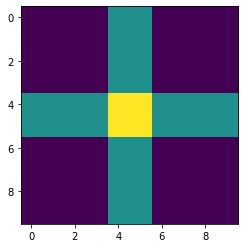

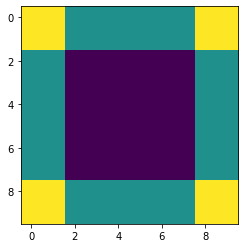

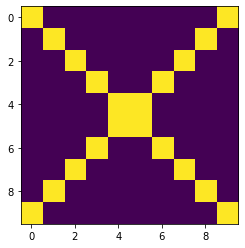

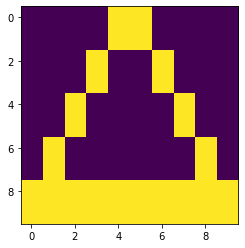

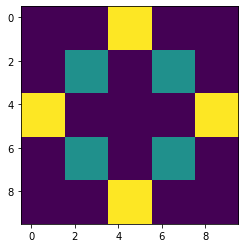

torch.Size([10000])
torch.Size([10000, 10, 10])


In [2]:
# Generate patterns
np.random.seed(42)
torch.manual_seed(42)

n = 10000
img_size = 10
window_size = 5
empty_img = torch.zeros((10,10))
original_mark = 5
num_windows = (img_size//window_size)**2
n_unseen = 2000
pert_size = 0.1

# 0, cross
cross_pattern = empty_img.clone().detach()
center = ((img_size-1)//2)
cross_pattern[center:center+2, :img_size] += original_mark
cross_pattern[:img_size, center:center+2] += original_mark
plt.imshow(cross_pattern)
plt.show()

# 1, square
square_pattern = empty_img.clone().detach()
square_pattern[:2,:img_size] += original_mark
square_pattern[:img_size, :2] += original_mark
square_pattern[:img_size,(img_size-2):] += original_mark
square_pattern[(img_size-2):, :img_size] += original_mark
plt.imshow(square_pattern)
plt.show()

# 2, diagonals
diagonals_pattern = empty_img.clone().detach()
for i in range(img_size):
    diagonals_pattern[i,i]+=original_mark
    diagonals_pattern[i,(img_size-1-i)]+=original_mark
plt.imshow(diagonals_pattern)
plt.show()

# 3, triangle
triangle_pattern = empty_img.clone().detach()
center = ((img_size-1)//2)
for i in range(img_size):
    if i%2==0:
        triangle_pattern[i,center-(i//2)]+=original_mark
        triangle_pattern[i+1,center-(i//2)]+=original_mark
        
        triangle_pattern[i,(center+(i//2)+1)]+=original_mark
        triangle_pattern[i+1,(center+(i//2)+1)]+=original_mark
    else:
        continue
triangle_pattern[(img_size-2):img_size,1:img_size-1]+=original_mark

plt.imshow(triangle_pattern)
plt.show()

# 4, diamond
diamond_pattern = empty_img.clone().detach()
center = ((img_size-1)//2)
for i in range(center-1):
    diamond_pattern[i*2:(i*2)+2,center+(i*2):center+(i*2)+2]+=original_mark
    diamond_pattern[img_size-(i*2)-2:img_size-(i*2)
                    ,center+(i*2):center+(i*2)+2]+=original_mark

    diamond_pattern[i*2:(i*2)+2,center-(i*2):center-(i*2)+2]+=original_mark
    diamond_pattern[img_size-(i*2)-2:img_size-(i*2)
                    ,center-(i*2):center-(i*2)+2]+=original_mark

plt.imshow(diamond_pattern)
plt.show()

patterns_dict = {0: cross_pattern, 1: square_pattern, 
                 2: diagonals_pattern, 3: triangle_pattern, 
                 4: diamond_pattern}

imgs_shape_ind = torch.multinomial(
    torch.tensor([1/5,1/5,1/5,1/5,1/5]), n, replacement=True)
print(imgs_shape_ind.shape)
imgs = torch.cat([patterns_dict[i.item()] for i in imgs_shape_ind]).reshape(n, 
                                                                          img_size, 
                                                                          img_size)

print(imgs.shape)

In [3]:
imgs_shape_ind.reshape(-1, 1).shape, imgs.shape

(torch.Size([10000, 1]), torch.Size([10000, 10, 10]))

In [4]:
n_components = n_comp = 1
cca = CCA(n_components=1)
cca.fit(imgs_shape_ind.reshape(-1, 1), imgs.reshape(n, -1))
print("canonical correlation test, imgs_shape_ind, imgs:", 
      np.diag(np.corrcoef(cca.x_scores_, cca.y_scores_, rowvar=False)[:n_comp, n_comp:]))


canonical correlation test, imgs_shape_ind, imgs: [1.]


In [5]:
W_prob_giv_z_dict = {0: [1/4, 1/2,1/4,0], 
                    1: [1,3, 0, 1/3, 1/3],
                    2: [1/2,1/6, 1/6, 1/6],
                    3: [0, 0, 1/2, 1/2],
                    4: [2/3, 0, 0, 1/3]}

W = [torch.multinomial(torch.tensor(W_prob_giv_z_dict[z.item()]), 1) for z in imgs_shape_ind]
f_w = torch.cat([torch.zeros(img_size,img_size) 
               for _ in range(n)]).reshape((n,img_size,img_size))

for i, w in enumerate(tqdm(W)):
    mv = torch.distributions.multivariate_normal.MultivariateNormal(torch.tensor(w).float(), torch.eye(2))
    for _ in range(1000):
        sample = mv.sample()
        if ((sample > torch.tensor([0,0])).all()) and ((sample < torch.tensor((10,10))).all()):
            f_w[i][int(sample[0]), int(sample[1])] += pert_size  

100%|██████████| 10000/10000 [17:16<00:00,  9.65it/s]


In [6]:
W_unseen = [torch.tensor([5]) for _ in range(n_unseen)]
f_w_unseen = torch.cat([torch.zeros(img_size,img_size) 
               for _ in range(n_unseen)]).reshape((n_unseen,img_size,img_size))

for i, w in enumerate(tqdm(W_unseen)):
    mv = torch.distributions.multivariate_normal.MultivariateNormal(torch.tensor(w).float(), torch.eye(2))
    for _ in range(1000):
        sample = mv.sample()
        if ((sample > torch.tensor([0,0])).all()) and ((sample < torch.tensor((10,10))).all()):
            f_w_unseen[i][int(sample[0]), int(sample[1])] += pert_size

100%|██████████| 2000/2000 [04:14<00:00,  7.86it/s]


In [7]:
torch.manual_seed(42)
phi_Convolutions_based_on_Z = {0: torch.nn.Conv1d(in_channels=window_size, out_channels=1, kernel_size=5),
                              1: torch.nn.Conv1d(in_channels=window_size, out_channels=1, kernel_size=5),
                              2: torch.nn.Conv1d(in_channels=window_size, out_channels=1, kernel_size=5),
                              3: torch.nn.Conv1d(in_channels=window_size, out_channels=1, kernel_size=5),
                              4: torch.nn.Conv1d(in_channels=window_size, out_channels=1, kernel_size=5)}

Z = imgs
Z_unseen = imgs[:n_unseen, :, :]


# create the "seen" (training) intervention dataset
X = (imgs+f_w+torch.normal(mean=0., std=.5, size=imgs.shape)).reshape(n, img_size**2)
print(X.shape)

phis = []
for x, z in zip(X, imgs_shape_ind):
    phis.append([phi_Convolutions_based_on_Z[z.item()]
                 (x[i * (window_size**2):(i + 1) * (window_size**2)].
                  reshape(1,window_size, window_size)) for i in range(num_windows)])
flat_list = [item for sublist in phis for item in sublist]
phis_flattened_tensor = torch.FloatTensor(flat_list)
phis = phis_flattened_tensor.reshape(n, num_windows)

print(phis.shape)
Y = 0.7*phis[:,0]+0*phis[:,1]+0*phis[:,2]-0.5*phis[:,3]+torch.normal(mean=0., std=.1, size=(1,))
Y_no_noise = 0.7*phis[:,0]+0*phis[:,1]+0*phis[:,2]-0.5*phis[:,3]
print(Y.shape)


# create the unseen intervention dataset
X_unseen = (imgs[:n_unseen, :,:]+f_w_unseen+torch.normal(mean=0., std=.5, size=imgs[:n_unseen, :,:].shape)).reshape(n_unseen, img_size**2)
print(X_unseen.shape)

phis_unseen = []
for x, z in zip(X_unseen, imgs_shape_ind[:n_unseen]):
    phis_unseen.append([phi_Convolutions_based_on_Z[z.item()]
                        (x[i * (window_size**2):(i + 1) * (window_size**2)]
                         .reshape(1, window_size, window_size)) for i in range(num_windows)])

flat_list = [item for sublist in phis_unseen for item in sublist]
phis_flattened_tensor = torch.FloatTensor(flat_list)
phis_unseen = phis_flattened_tensor.reshape(n_unseen, num_windows)

print(phis_unseen.shape)
Y_unseen = 0.7*phis_unseen[:,0]+0*phis_unseen[:,1]+\
0*phis_unseen[:,2]-0.5*phis_unseen[:,3]+torch.normal(mean=0., std=.1, size=(1,))
Y_unseen_no_noise = 0.7*phis_unseen[:,0]+\
0*phis_unseen[:,1]+0*phis_unseen[:,2]-0.5*phis_unseen[:,3]

weights_phis_groundtruth = [0.7, 0, 0, -0.5]
print(Y_unseen.shape)
X = X.reshape(n, img_size, img_size)
X_unseen = X_unseen.reshape(n_unseen, img_size, img_size)

torch.Size([10000, 100])
torch.Size([10000, 4])
torch.Size([10000])
torch.Size([2000, 100])
torch.Size([2000, 4])
torch.Size([2000])


### Inspect resulting dataset

old image


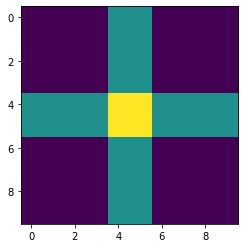

new image


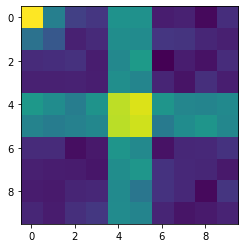

new image unseen


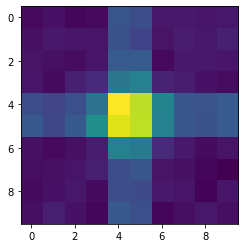

(tensor([-5.5346, -5.4430, -5.3814,  ...,  4.5757,  4.6210,  4.6790]), tensor([1, 1, 1,  ..., 1, 1, 1]))


In [8]:
print("old image")
plt.imshow(imgs[0])
plt.show()
print("new image")
plt.imshow(X[0])
plt.savefig("example_ImgPert.png")
plt.show()
print("new image unseen")
plt.imshow(X_unseen[0])
plt.show()
print(Y.unique(return_counts=True))

old image


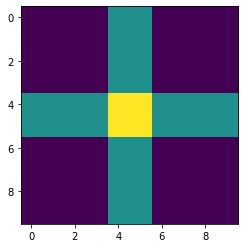

new image


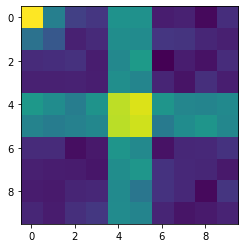

new image unseen


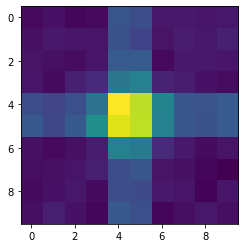

(tensor([-3.1489, -3.1391, -3.1184,  ...,  1.6194,  1.6508,  1.6613]), tensor([1, 1, 1,  ..., 1, 1, 1]))


In [43]:
print("old image")
plt.imshow(imgs[0])
plt.show()
print("new image")
plt.imshow(X[0])
plt.savefig("example_ImgPert.png")
plt.show()
print("new image unseen")
plt.imshow(X_unseen[0])
plt.show()
print(Y.unique(return_counts=True))

In [9]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(np.array([0,1,2,3,4]).reshape(-1,1))
enc.transform(np.array([3]).reshape(-1,1)).toarray()[0]

array([0., 0., 0., 1., 0.])

In [10]:
df_train_val = pd.DataFrame.from_dict({
    'Z': [i.numpy().reshape(-1) for i in Z], 
    'W': [i.numpy().reshape(-1) for i in W], 
    'X': [i.numpy().reshape(-1) for i in X], 
    'phis': [i.numpy().reshape(-1) for i in phis], 
    'Y':[i.item() for i in Y],
    'img_ind': [i.item() for i in imgs_shape_ind]
})
df_test_unseen = pd.DataFrame.from_dict({
    'Z': [i.numpy().reshape(-1) for i in Z_unseen], 
    'W': [i.numpy().reshape(-1) for i in W_unseen], 
    'X': [i.numpy().reshape(-1) for i in X_unseen], 
    'phis': [i.numpy().reshape(-1) for i in phis_unseen], 
    'Y':[i.item() for i in Y_unseen],
    'img_ind': [i.item() for i in imgs_shape_ind[:2000]]
})


def one_hot(x):
    return enc.transform(np.array([x]).reshape(-1,1)).toarray()[0]

df_train_val['W_one_hot'] = df_train_val['W'].apply(lambda x: one_hot(x)) 
df_test_unseen['W_one_hot'] = df_test_unseen['W'].apply(lambda x: one_hot(x)) 

df_train_val = df_train_val.sample(frac = 1)
df_test_unseen = df_test_unseen.sample(frac = 1)

# convert higher-dim variables to individual dataframe columns
df_train_val[['W_one_hot'+str(i) for i in range(df_train_val['W_one_hot'].iloc[0].shape[0])]] =\
    pd.DataFrame(df_train_val.W_one_hot.tolist(), index = df_train_val.index)
df_train_val.drop('W', axis=1, inplace=True)
df_train_val.drop('W_one_hot', axis=1, inplace=True)
df_train_val[['X'+str(i) for i in range(df_train_val['X'].iloc[0].shape[0])]] =\
    pd.DataFrame(df_train_val.X.tolist(), index = df_train_val.index)
df_train_val.drop('X', axis=1, inplace=True)
df_train_val[['phis'+str(i) for i in range(df_train_val['phis'].iloc[0].shape[0])]] =\
    pd.DataFrame(df_train_val.phis.tolist(), index = df_train_val.index)
df_train_val.drop('phis', axis=1, inplace=True)
df_train_val[['Z'+str(i) for i in range(df_train_val['Z'].iloc[0].shape[0])]] =\
    pd.DataFrame(df_train_val.Z.tolist(), index = df_train_val.index)
df_train_val.drop('Z', axis=1, inplace=True)

df_test_unseen[['W_one_hot'+str(i) for i in range(df_test_unseen['W_one_hot'].iloc[0].shape[0])]] =\
    pd.DataFrame(df_test_unseen.W_one_hot.tolist(), index = df_test_unseen.index)
df_test_unseen.drop('W', axis=1, inplace=True)
df_test_unseen.drop('W_one_hot', axis=1, inplace=True)
df_test_unseen[['X'+str(i) for i in range(df_test_unseen['X'].iloc[0].shape[0])]] =\
    pd.DataFrame(df_test_unseen.X.tolist(), index = df_test_unseen.index)
df_test_unseen.drop('X', axis=1, inplace=True)
df_test_unseen[['phis'+str(i) for i in range(df_test_unseen['phis'].iloc[0].shape[0])]] =\
    pd.DataFrame(df_test_unseen.phis.tolist(), index = df_test_unseen.index)
df_test_unseen.drop('phis', axis=1, inplace=True)
df_test_unseen[['Z'+str(i) for i in range(df_test_unseen['Z'].iloc[0].shape[0])]] =\
    pd.DataFrame(df_test_unseen.Z.tolist(), index = df_test_unseen.index)
df_test_unseen.drop('Z', axis=1, inplace=True)


df_train_val = shuffle(df_train_val)
df_test_unseen = shuffle(df_test_unseen)

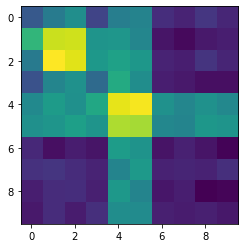

In [11]:
plt.imshow(np.array(df_train_val[['X'+str(i) for i in range(100)]].iloc[25]).reshape(10,10))
plt.show()

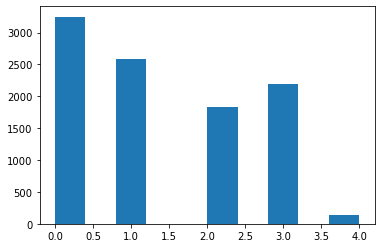

In [13]:
plt.hist(torch.cat(W).reshape(1, -1))
plt.show()

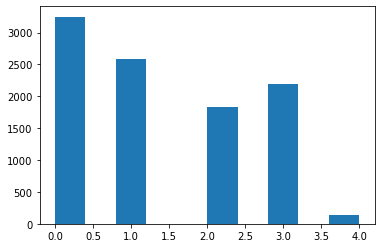

In [22]:
plt.hist(torch.cat(W).reshape(1, -1))
plt.show()

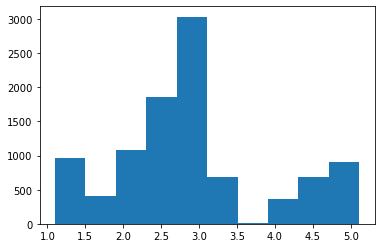

In [23]:
plt.hist(torch.mean(X, axis=(1,2)).reshape(1, -1))
plt.show()

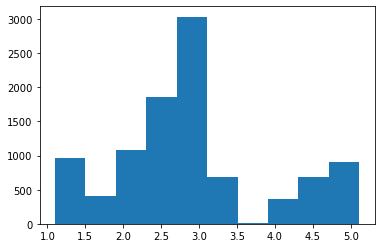

In [14]:
plt.hist(torch.mean(X, axis=(1,2)).reshape(1, -1))
plt.show()

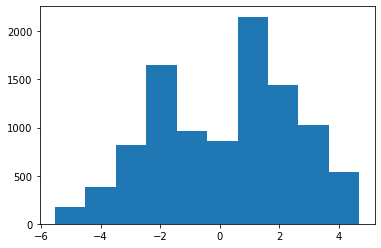

In [14]:
plt.hist(df_train_val['Y'])
plt.show()

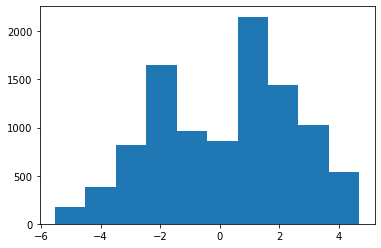

In [15]:
plt.hist(df_train_val['Y'])
plt.show()

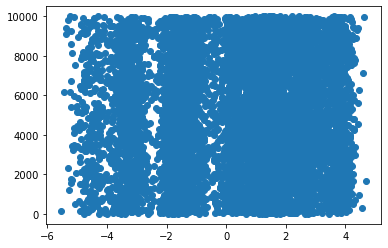

In [15]:
plt.scatter(df_train_val['Y'], list(range(len(df_train_val['Y']))))

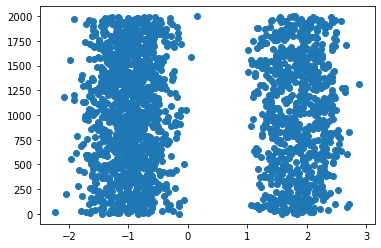

In [16]:
plt.scatter(df_test_unseen['Y'], list(range(len(df_test_unseen['Y']))))

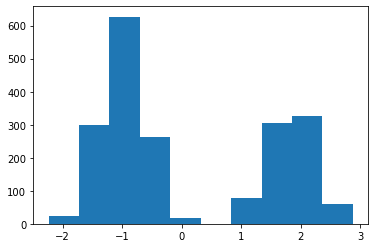

In [24]:
plt.hist(Y_unseen.reshape(1, -1))
plt.show()

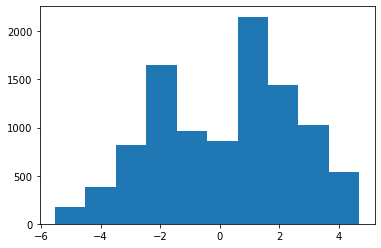

In [25]:
plt.hist(Y.reshape(1, -1))
plt.show()

### Export dataset

In [19]:
np.random.seed(42)
weights_phis_groundtruth = [0.7, 0, 0, -0.5]
total_df_seen = df_train_val[
                    list(df_train_val.columns[df_train_val.columns.str.contains('Z')])+
                    list(df_train_val.columns[df_train_val.columns.str.contains('W_one_hot')])+
                    list(df_train_val.columns[df_train_val.columns.str.contains('X')])+['Y']
                    + list(df_train_val.columns[df_train_val.columns.str.contains('phis')])
]


total_df_unseen = df_test_unseen[list(df_test_unseen.columns[df_test_unseen.columns.str.contains('Z')])+
                                list(df_test_unseen.columns[df_test_unseen.columns.str.contains('W_one_hot')])+
                                list(df_test_unseen.columns[df_test_unseen.columns.str.contains('X')])+['Y']
                                + list(df_test_unseen.columns[df_test_unseen.columns.str.contains('phis')])]

total_df_seen = shuffle(total_df_seen)
total_df_seen_train = total_df_seen.iloc[:int(len(total_df_seen)*0.9)]
total_df_seen_test = total_df_seen.iloc[int(len(total_df_seen)*0.9):]

total_df_unseen = shuffle(total_df_unseen)
df_test_unseen_train = total_df_unseen.iloc[:int(len(total_df_unseen)*0.8)]
df_test_unseen_test = total_df_unseen.iloc[int(len(total_df_unseen)*0.8):]

total_df_seen = total_df_seen.to_numpy()
total_df_seen_train = total_df_seen_train.to_numpy()
total_df_seen_test = total_df_seen_test.to_numpy()

test_unseen_train = df_test_unseen_train.to_numpy()
test_unseen_test = df_test_unseen_test.to_numpy()

print(total_df_seen_train.shape, total_df_seen_test.shape, 
      test_unseen_train.shape, test_unseen_test.shape)

Path('../../data/ImgPertSim/').mkdir(parents=True, exist_ok=True)
np.savez_compressed('../../data/ImgPertSim/ImgPertSim_trainset_seen_train.npz', total_df_seen_train)
np.savez_compressed('../../data/ImgPertSim/ImgPertSim_trainset_seen_test.npz', total_df_seen_test)
np.savez_compressed('../../data/ImgPertSim/ImgPertSim_testset_unseen_train.npz', test_unseen_train)
np.savez_compressed('../../data/ImgPertSim/ImgPertSim_testset_unseen_test.npz', test_unseen_test)
np.savez_compressed('../../data/ImgPertSim/ImgPertSim_params.npz', weights_phis_groundtruth)

(9000, 210) (1000, 210) (1600, 210) (400, 210)


## Additional experiments: create 100 versions of datasets with different coefficients for Y

The exploration in the next few cells explains how we chose the distribution of Y parameters and std. of the noise. The aim was to find similar stats to the ones for the original Y setting above. Stats for Y above: mean 0.181, std. 1.45

In [246]:
np.random.seed(42)

In [252]:
df_train_stats = {'mean': [], 'std': [], 'min': [], 'max': []}
df_test_unseen_stats = {'mean': [], 'std': [], 'min': [], 'max': []}
num_runs_diff_Y = 100

for run in range(num_runs_diff_Y):
    weights_phis_groundtruth = np.random.uniform(-.3, .3, 4)
    zero_out_inds = np.random.choice(4, 2, replace=False)
    weights_phis_groundtruth[zero_out_inds] = 0

    Y = torch.tensor(weights_phis_groundtruth, dtype=torch.float)@phis.T+torch.normal(mean=0., std=.01, size=(1,))
    Y_unseen = torch.tensor(weights_phis_groundtruth, dtype=torch.float)@phis_unseen.T+torch.normal(mean=0., std=.01, size=(1,))

    df_train_val['Y'] = [i.item() for i in Y]
    df_test_unseen['Y'] = [i.item() for i in Y_unseen]
    
    df_train_stats['mean'].append(np.mean(df_train_val['Y']))
    df_train_stats['std'].append(np.std(df_train_val['Y']))
    df_train_stats['min'].append(np.min(df_train_val['Y']))
    df_train_stats['max'].append(np.max(df_train_val['Y']))
    
    df_test_unseen_stats['mean'].append(np.mean(df_test_unseen['Y']))
    df_test_unseen_stats['std'].append(np.std(df_test_unseen['Y']))
    df_test_unseen_stats['min'].append(np.min(df_test_unseen['Y']))
    df_test_unseen_stats['max'].append(np.max(df_test_unseen['Y']))
    

(array([ 8.,  9.,  7., 13., 17., 18., 15.,  5.,  3.,  5.]),
 array([-0.56360266, -0.43272416, -0.30184566, -0.17096716, -0.04008866,
         0.09078984,  0.22166834,  0.35254684,  0.48342534,  0.61430384,
         0.74518234]),
 <BarContainer object of 10 artists>)

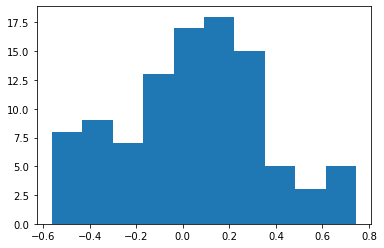

In [253]:
plt.hist(df_train_stats['mean'])

(array([ 5., 10.,  5.,  8., 20., 19., 12., 11.,  3.,  7.]),
 array([-0.61076646, -0.48030624, -0.34984601, -0.21938579, -0.08892556,
         0.04153466,  0.17199488,  0.30245511,  0.43291533,  0.56337556,
         0.69383578]),
 <BarContainer object of 10 artists>)

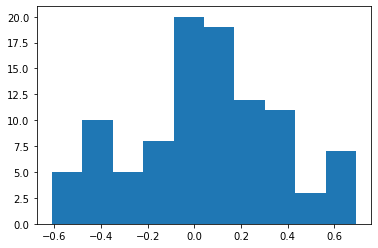

In [254]:
plt.hist(df_test_unseen_stats['mean'])

(array([16., 28., 13., 17.,  9.,  3.,  8.,  4.,  0.,  2.]),
 array([0.05095055, 0.26074426, 0.47053796, 0.68033166, 0.89012536,
        1.09991906, 1.30971277, 1.51950647, 1.72930017, 1.93909387,
        2.14888757]),
 <BarContainer object of 10 artists>)

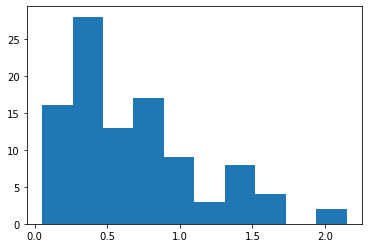

In [255]:
plt.hist(df_train_stats['std'])

(array([12., 16., 23., 16., 11., 15.,  4.,  1.,  1.,  1.]),
 array([0.05018031, 0.25583998, 0.46149964, 0.6671593 , 0.87281897,
        1.07847863, 1.2841383 , 1.48979796, 1.69545763, 1.90111729,
        2.10677696]),
 <BarContainer object of 10 artists>)

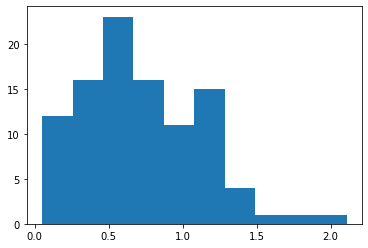

In [256]:
plt.hist(df_test_unseen_stats['std'])

In [258]:
np.random.seed(42)
num_runs_diff_Y = 1500
for run in range(num_runs_diff_Y):
    # sample coefficients from uniform dist, zero out 2 at random
    weights_phis_groundtruth = np.random.uniform(-.3, .3, 4)
    zero_out_inds = np.random.choice(4, 2, replace=False)
    weights_phis_groundtruth[zero_out_inds] = 0
    
    Y = torch.tensor(weights_phis_groundtruth, dtype=torch.float)@phis.T+torch.normal(mean=0., std=.01, size=(1,))
    Y_unseen = torch.tensor(weights_phis_groundtruth, dtype=torch.float)@phis_unseen.T+torch.normal(mean=0., std=.01, size=(1,))
    
    df_train_val['Y'] = [i.item() for i in Y]
    df_test_unseen['Y'] = [i.item() for i in Y_unseen]
    
    total_df_seen = df_train_val[
                    list(df_train_val.columns[df_train_val.columns.str.contains('Z')])+
                    list(df_train_val.columns[df_train_val.columns.str.contains('W_one_hot')])+
                    list(df_train_val.columns[df_train_val.columns.str.contains('X')])+['Y']
                    + list(df_train_val.columns[df_train_val.columns.str.contains('phis')])
    ]


    total_df_unseen = df_test_unseen[list(df_test_unseen.columns[df_test_unseen.columns.str.contains('Z')])+
                                    list(df_test_unseen.columns[df_test_unseen.columns.str.contains('W_one_hot')])+
                                    list(df_test_unseen.columns[df_test_unseen.columns.str.contains('X')])+['Y']
                                    + list(df_test_unseen.columns[df_test_unseen.columns.str.contains('phis')])]

    total_df_seen = shuffle(total_df_seen)
    total_df_seen_train = total_df_seen.iloc[:int(len(total_df_seen)*0.9)]
    total_df_seen_test = total_df_seen.iloc[int(len(total_df_seen)*0.9):]

    total_df_unseen = shuffle(total_df_unseen)
    df_test_unseen_train = total_df_unseen.iloc[:int(len(total_df_unseen)*0.8)]
    df_test_unseen_test = total_df_unseen.iloc[int(len(total_df_unseen)*0.8):]

    total_df_seen = total_df_seen.to_numpy()
    total_df_seen_train = total_df_seen_train.to_numpy()
    total_df_seen_test = total_df_seen_test.to_numpy()

    test_unseen_train = df_test_unseen_train.to_numpy()
    test_unseen_test = df_test_unseen_test.to_numpy()

    Path('../../data/ImgPertSim/diffY/').mkdir(parents=True, exist_ok=True)
    np.savez_compressed('../../data/ImgPertSim/diffY/ImgPertSim_unif{}_trainset_seen_train.npz'.format(run), total_df_seen_train)
    np.savez_compressed('../../data/ImgPertSim/diffY/ImgPertSim_unif{}_trainset_seen_test.npz'.format(run), total_df_seen_test)
    np.savez_compressed('../../data/ImgPertSim/diffY/ImgPertSim_unif{}_testset_unseen_train.npz'.format(run), test_unseen_train)
    np.savez_compressed('../../data/ImgPertSim/diffY/ImgPertSim_unif{}_testset_unseen_test.npz'.format(run), test_unseen_test)
    np.savez_compressed('../../data/ImgPertSim/diffY/ImgPertSim_unif{}_params.npz'.format(run), weights_phis_groundtruth)